<a href="https://colab.research.google.com/github/Varun-Mulchandani/Reddit-Flair-Classifier/blob/master/Final_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, the approach I have used a Stacked LSTM network for the mulit-class classification task.
 - Tensorflow==1.15.0
 - Keras==2.2.5

Import and install the necessary libraries

In [60]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [63]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from keras import regularizers

Loading the data

In [0]:
path = '/content/'
train_file = f'{path}reddit_cleaned_data.csv'

In [0]:
train = pd.read_csv(train_file)

In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [79]:
train.head(5)

,flair,title,score,id,author,comms_num,body,url
1588,Sports,Bala movie A mix new old Analysis,16,du8jny,nibirdeka,4,I expecting nothing movie Bala majorly 2 thing...,https://www.reddit.com/r/india/comments/du8jny...
548,Photography,I’ve Recently generated interest photography t...,4,aaakn4,thesarcasticpage,14,NaN,https://i.redd.it/9tcehs8vz0721.jpg
1322,AskIndia,askindia Need advice buying new bike,17,by7svp,nagasadhu,24,Hey guys\n\nI looking buy new bike I ride city...,https://www.reddit.com/r/india/comments/by7svp...
1166,Policy/Economy,Central bank liquidity withdrawal Shortterm un...,19,6nek45,roytrivia_93,1,NaN,http://economictimes.indiatimes.com/markets/st...
1187,AskIndia,What Gotra,37,a2nsgt,ab370a1d,32,Hey theres term quite popular right news debat...,https://www.reddit.com/r/india/comments/a2nsgt...


In [0]:
list_sentences_train = train['title'].fillna('_na_').values + ' SEP ' + train['author'].fillna('_na_').values
list_classes = ["AskIndia", "Non-Political", 
          "Scheduled", "Photography", "Science/Technology",
          "Politics", "Business/Finance", "Policy/Economy",
          "Sports", "Food", 'Coronavirus']

Getting the initial counts

In [81]:
train.flair.value_counts()

Politics              249
Coronavirus           248
Food                  244
Scheduled             234
Business/Finance      233
Sports                232
AskIndia              231
Photography           222
Science/Technology    221
Policy/Economy        220
Non-Political         216
Name: flair, dtype: int64

Helper function to visualise the titles

In [0]:
def print_title(index):
  example = train[train.index == index][['title','flair']].values[0]
  if len(example) > 0:
    print(example[0])
    print('Flair:', example[1])

Cleaning the data
- Removing unwanted symbols
- Removing stopwords

In [0]:
train = train.reset_index(drop = True)
replace = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
stopword_s = set(stopwords.words('english'))

def clean(title):
  title = title.lower()
  title = replace.sub(' ', title)
  title = symbols.sub('', title)
  title = ' '.join(word for word in title.split() if word not in stopword_s)

  return title
train['title'] = train['title'].apply(clean)

In [84]:
print_title(100)

coronavirus threat ventilators shields mahindra starts producing sanitizers
Flair: Coronavirus


Text Augmentation - To reduce overfitting
 - Here, synonym based text augmentation is used.
 - Each title in the dataset is extracted.
 - A random word is replaced with its synonym only if the word has a synonym.
 - It is appended to the dataframe along with the same flair and the author name.

In [85]:
import nltk 
from nltk.corpus import wordnet 
synonyms = [] 
for syn in wordnet.synsets("good"): 
    for l in syn.lemmas(): 
        synonyms.append(l.name())
count = 2550
for i,j,k in zip(list(train['title']), list(train['flair']), list(train['author'])):
  inter = i.split(' ')
  synonyms = []
  index = random.randrange(0, len(inter))
  for syn in wordnet.synsets(inter[index]):
    for l in syn.lemmas():
      synonyms.append(l.name())
  print(synonyms)
  if len(synonyms) != 0:
    inter[index] = synonyms[0]
    final_title = ' '.join(x for x in inter)
    print(final_title)
    train.loc[i] = [j] + [final_title] + ['na'] + ['na'] + [k] + ['na']+ ['na']+ ['na']


['mix', 'premix', 'mix', 'mixture', 'mix', 'commixture', 'admixture', 'mixture', 'intermixture', 'mixing', 'blend', 'flux', 'mix', 'conflate', 'commingle', 'immix', 'fuse', 'coalesce', 'meld', 'combine', 'merge', 'desegregate', 'integrate', 'mix', 'mix', 'mix', 'mix_in', 'mix', 'mingle', 'commix', 'unify', 'amalgamate', 'shuffle', 'ruffle', 'mix']
bala movie mix new old analysis
[]
['need', 'demand', 'need', 'want', 'motivation', 'motive', 'need', 'indigence', 'need', 'penury', 'pauperism', 'pauperization', 'necessitate', 'ask', 'postulate', 'need', 'require', 'take', 'involve', 'call_for', 'demand', 'want', 'need', 'require', 'need']
askindia need advice buying new bike
['bank', 'depository_financial_institution', 'bank', 'banking_concern', 'banking_company', 'bank', 'bank', 'bank', 'bank', 'bank', 'cant', 'camber', 'savings_bank', 'coin_bank', 'money_box', 'bank', 'bank', 'bank_building', 'bank', 'bank', 'bank', 'bank', 'bank', 'bank', 'deposit', 'bank', 'bank', 'trust', 'swear', 're

New count

In [43]:
train.flair.value_counts()

Food                  445
Politics              434
Scheduled             429
Coronavirus           426
Sports                418
Business/Finance      415
Photography           414
Science/Technology    404
AskIndia              396
Non-Political         389
Policy/Economy        386
Name: flair, dtype: int64

Creating a Tokenizer

In [44]:
max_no_word = 50000
max_seq_length = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words = max_no_word, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(train['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 7302 unique tokens


Tokenizing the inputs and padding them:

In [45]:
x = tokenizer.texts_to_sequences(train['title'].values)
x = pad_sequences(x, maxlen = max_seq_length)
print('Shape of data tensor:', x.shape)

Shape of data tensor: (4556, 250)


Creating indicators for target values:

In [46]:
y = pd.get_dummies(train['flair']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (4556, 11)


Splitting Data into train and test sets

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4100, 250) (4100, 11)
(456, 250) (456, 11)


Building a Stacked LSTM model:


Note: I have used regularisers in the Dense layer to prevent overfitting.

In [48]:
model = Sequential()
model.add(Embedding(max_no_word, embedding_dim, input_length = x.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(100, activation = 'tanh'))
model.add(Dense(11, activation = 'softmax',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)              

Training

In [50]:
epochs = 20
batch_size = 64
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, shuffle = True)

Train on 3690 samples, validate on 410 samples
Epoch 1/20
3690/3690 [==============================] - 84s 23ms/step - loss: 3.1584 - acc: 0.1127 - val_loss: 3.0329 - val_acc: 0.1878
Epoch 2/20
3690/3690 [==============================] - 86s 23ms/step - loss: 2.7537 - acc: 0.2407 - val_loss: 2.5095 - val_acc: 0.2829
Epoch 3/20
3690/3690 [==============================] - 84s 23ms/step - loss: 2.1487 - acc: 0.4688 - val_loss: 1.9765 - val_acc: 0.6000
Epoch 4/20
3690/3690 [==============================] - 83s 22ms/step - loss: 1.5946 - acc: 0.7111 - val_loss: 1.6845 - val_acc: 0.7244
Epoch 5/20
3690/3690 [==============================] - 83s 22ms/step - loss: 1.2856 - acc: 0.8320 - val_loss: 1.5733 - val_acc: 0.7610
Epoch 6/20
3690/3690 [==============================] - 83s 22ms/step - loss: 1.1510 - acc: 0.8794 - val_loss: 1.5065 - val_acc: 0.8098
Epoch 7/20
3690/3690 [==============================] - 83s 22ms/step - loss: 1.0667 - acc: 0.9041 - val_loss: 1.4492 - val_acc: 0.8171
E

Testing

In [51]:
acc = model.evaluate(x_test, y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(acc[0],acc[1]))

456/456 [==============================] - 3s 6ms/step
Test set
 Loss: 1.018
 Accuracy: 0.846


Visualising loss and accuracy in train and test sets:

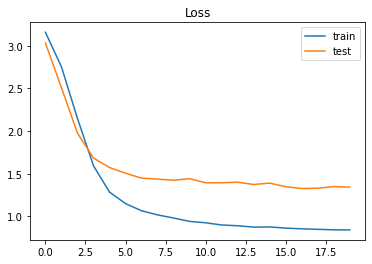

In [56]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

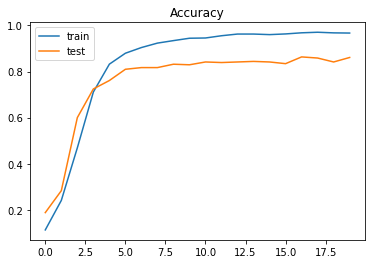

In [58]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Function to generate flair which will be used in the application script

In [0]:
def generate_flair(title):
  title = [title]
  seq = tokenizer.texts_to_sequences(title)
  padded = pad_sequences(seq, maxlen = max_seq_length)
  pred = model.predict(padded)
  return list_classes[np.argmax(pred)]

Storing the model in a pickle file

In [0]:
import pickle
pickle.dump(model, open('lstm_model.pkl','wb'))

Loading the model

In [0]:
model = pickle.load(open('Classifier_bert.pkl','rb'))